## Projet D'ETL

In [1]:
# Importation des librairies
from dotenv import load_dotenv
import requests
import pandas as pd
import folium
import sqlite3
import time
import os

c:\Users\PC\miniconda3\envs\bigdata\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [26]:
# On installe la librairie "python-dotenv" afin de pouvoir utiliser un fichier .env se trouvant dans notre repertoire. 
# pip install python-dotenv


Le but de ce projet est d'extraire des données du site https://openweathermap.org/ en utilisant une API. On y trouve les données météorologiques du n'importe quel endroit de la planète. On extrait ces données composées des noms de ville, de leur latitude et longitude ainsi que de leurs températures. Après les avoir nettoyé, on les utilise pour tracer une carte avec la librairie "folium" en plaçant un point sur chacune des villes avec leurs températures. 
Enfin, on stocke ces données dans une base de donnée SQL créée avec SQLite.

#### 1. Création d'un compte sur https://openweathermap.org/

Après avoir créé un compte, on clique sur mon nom d'utilisateur se trouvant en haut à droite puis sur "My API Keys".

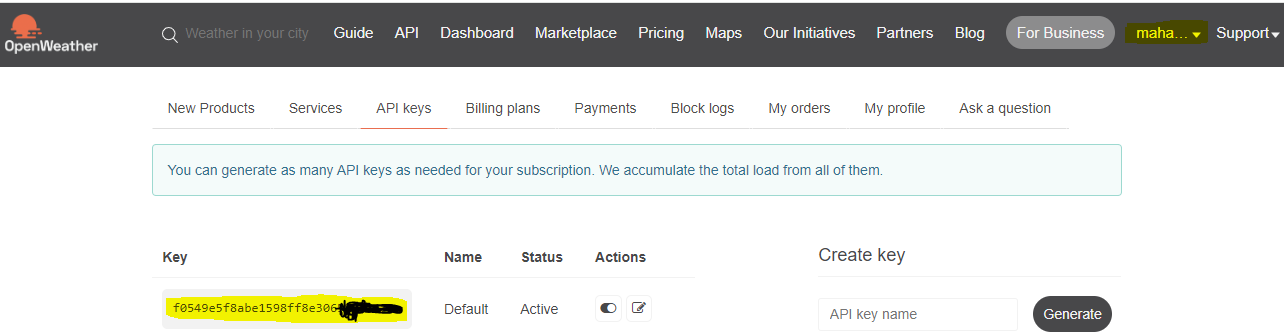

### 2. Extraction de données

Chaque ville a un ID unique. On les utilise pour importer ces données.

In [3]:
# On charge le fichier ".env" qui comporte notre clé d'API. 
# Cette méthode nous permet d'éviter d'exposer notre clé dans le repertoire Github.
load_dotenv(dotenv_path='cle.env')

True

In [4]:
# Fonction pour diviser une liste d'IDs en sous-groupes de taille égale.
# Chaque groupe de 20 IDs correspond à une requête API, respectant la limite de l'API d'OpenWeatherMap,
# qui impose une limite de 20 villes par requête.
# Cela permet d'envoyer plusieurs requêtes et d'agréger les résultats ensuite.
def chunkify(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [5]:
# Liste complète des IDs des villes que nous voulons interroger pour récupérer les données météo.
# Chaque ID représente une ville spécifique, et ces IDs seront utilisés pour interroger l'API OpenWeatherMap.
# Ces IDs sont ensuite divisés en groupes de 20 par la fonction chunkify.
ids = [
    937148, 2507480, 2240449, 2392087, 933773, 2357048, 425378, 2220957, 3374333, 921772, 
    2279755, 223817, 360630, 343300, 934985, 344979, 2399697, 2413876, 2306104, 2422465, 
    2374775, 184745, 932505, 2274895, 2210247, 1070940, 927967, 2460596, 2538475, 934154, 
    2377450, 1040652, 3352136, 2440485, 2352778, 2389853, 2314302, 202061, 2410763, 
    2253354, 241131, 2406769, 53654, 379252, 373303, 160196, 2427123, 2365267, 2464470, 
    232422, 909137, 890299
      ]

In [6]:
# Liste complète des IDs des villes que nous voulons interroger pour récupérer les données météo.
# Chaque ID représente une ville spécifique, et ces IDs seront utilisés pour interroger l'API OpenWeatherMap.
# Ces IDs sont ensuite divisés en groupes de 20 par la fonction chunkify.
chunks = list(chunkify(ids, 20))


In [7]:
# On récupère la clé API stockée dans le fichier .env à l'aide de la méthode os.getenv.
# Cela permet d'utiliser cette clé pour authentifier nos requêtes vers l'API OpenWeatherMap.
api_key = os.getenv('API_KEY')


In [8]:
# Initialisation d'une liste pour stocker toutes les données météo récupérées.
all_weather_data = []

# Pour chaque sous-groupe de villes (chunk), on envoie une requête à l'API OpenWeatherMap
# pour récupérer les données météo. Les résultats sont ensuite agrégés dans la liste `all_weather_data`.
for chunk in chunks:
    url = 'https://api.openweathermap.org/data/2.5/group'
    params = {
        'id': ','.join(map(str, chunk)),  # Convertir la liste d'IDs en une chaîne de caractères séparée par des virgules.
        'appid': api_key,  # Utilisation de la clé API pour authentification.
        'units': 'metric'  # Utilisation du système métrique (Celsius pour les températures).
    }
    
    # Envoyer la requête à l'API OpenWeatherMap
    res = requests.get(url, params=params)
    
    # Si la requête réussit (code 200), on ajoute les données à la liste.
    if res.status_code == 200:
        data = res.json()
        all_weather_data.extend(data['list'])  # Ajouter les données des villes récupérées à la liste all_weather_data.
    else:
        # En cas d'erreur (code différent de 200), afficher le message d'erreur.
        print(f"Erreur : {res.status_code}, {res.text}")


In [9]:
# Une fois toutes les données récupérées et agrégées, nous les convertissons en DataFrame pandas.
# Cela permet une manipulation plus simple et une analyse des données.
df = pd.json_normalize(all_weather_data)

# Afficher les premières lignes du DataFrame pour vérifier que les données ont été correctement récupérées.
df.head(4)


,weather,visibility,dt,id,name,coord.lon,coord.lat,sys.country,sys.timezone,sys.sunrise,...,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.sea_level,main.grnd_level,main.humidity,wind.speed,wind.deg,clouds.all
0,"[{'id': 801, 'main': 'Clouds', 'description': ...",10000,1729195758,2507480,Algiers,3.0420,36.7525,DZ,3600,1729144628,...,19.51,19.90,19.90,1021,1021,1015,60,3.60,260,20
1,"[{'id': 802, 'main': 'Clouds', 'description': ...",9000,1729195742,2240449,Luanda,13.2343,-8.8368,AO,3600,1729140173,...,25.72,25.00,25.00,1013,1013,1004,83,5.14,210,40
2,"[{'id': 804, 'main': 'Clouds', 'description': ...",10000,1729195746,2392087,Porto-Novo,2.6036,6.4965,BJ,3600,1729143338,...,24.90,24.11,24.11,1015,1015,1012,89,1.86,222,95
3,"[{'id': 800, 'main': 'Clear', 'description': '...",10000,1729195747,933773,Gaborone,25.9086,-24.6545,BW,7200,1729136423,...,21.87,22.66,22.66,1014,1014,904,34,2.85,30,0


In [10]:
# Noms de colonnes
df.columns

Index(['weather', 'visibility', 'dt', 'id', 'name', 'coord.lon', 'coord.lat',
       'sys.country', 'sys.timezone', 'sys.sunrise', 'sys.sunset', 'main.temp',
       'main.feels_like', 'main.temp_min', 'main.temp_max', 'main.pressure',
       'main.sea_level', 'main.grnd_level', 'main.humidity', 'wind.speed',
       'wind.deg', 'clouds.all'],
      dtype='object')

### 3. Transformation de données

On créé une fonction nous permettant d'effectuer quelques transformations sur mes données.

In [11]:
# Fonction de transformation des données extraites
# Cette fonction sélectionne uniquement les colonnes d'intérêt et les renomme pour une meilleure lisibilité.
def transform_data(df):
    # On sélectionne les colonnes utiles : l'ID de la ville, le nom, les coordonnées, 
    # le pays, la température et l'humidité.
    df_transformed = df[['id', 'name', 'coord.lon', 'coord.lat',
    'sys.country', 'main.temp', 'main.humidity']]
    
    # On renomme les colonnes pour qu'elles soient plus compréhensibles :
    # 'name' devient 'nom', 'coord.lon' devient 'longitude', etc.
    df_transformed.columns = ['id', 'nom', 'longitude', 'latitude',
    'sigle_pays', 'temperature', 'humidite']
    
    # On remplace les valeurs manquantes par des zéros pour éviter les erreurs lors des analyses ultérieures.
    df_transformed = df_transformed.fillna(0)
    
    # On retourne le DataFrame transformé.
    return df_transformed

In [12]:
df_transformed = transform_data(df)
df_transformed.head(8)

,id,nom,longitude,latitude,sigle_pays,temperature,humidite
0,2507480,Algiers,3.0420,36.7525,DZ,19.90,60
1,2240449,Luanda,13.2343,-8.8368,AO,25.00,83
2,2392087,Porto-Novo,2.6036,6.4965,BJ,24.11,89
3,933773,Gaborone,25.9086,-24.6545,BW,22.66,34
4,2357048,Ouagadougou,-1.5383,12.3642,BF,31.68,37
5,425378,Bujumbura,29.3644,-3.3822,BI,22.52,88
6,2220957,Yaounde,11.5167,3.8667,CM,20.25,99
7,3374333,Praia,-23.5087,14.9215,CV,26.30,89


In [13]:
df_transformed.shape

(50, 7)

In [14]:
# Afficher les villes qui commencent par la lettre "N"
df_transformed[df_transformed['nom'].str.startswith('N')]

,id,nom,longitude,latitude,sigle_pays,temperature,humidite
20,184745,Nairobi,36.8167,-1.2833,KE,19.62,64
29,2377450,Nouakchott,-15.9785,18.0858,MR,30.96,52
32,2440485,Niamey,2.1098,13.5137,NE,34.38,33
44,2427123,N'Djamena,15.0444,12.1067,TD,29.23,49


In [15]:
# Afficher les villes qui commencent par la lettre "R"
df_transformed[df_transformed['nom'].str.startswith('R')]

,id,nom,longitude,latitude,sigle_pays,temperature,humidite
27,2538475,Rabat,-6.8326,34.0132,MA,19.23,82


In [17]:
# Sigle de pays
print(df_transformed['sigle_pays'].unique())

['DZ' 'AO' 'BJ' 'BW' 'BF' 'BI' 'CM' 'CV' 'KM' 'CI' 'DJ' 'EG' 'ER' 'SZ'
 'ET' 'GA' 'GM' 'GH' 'GN' 'GW' 'KE' 'LS' 'LR' 'LY' 'MG' 'MW' 'ML' 'MA'
 'MU' 'MR' 'MZ' 'NA' 'NE' 'NG' 'CF' 'CD' 'RW' 'ST' 'SN' 'SC' 'SO' 'SD'
 'SS' 'TZ' 'TD' 'TG' 'TN' 'UG' 'ZM' 'ZW']


In [18]:
# Noms de ville
print(df_transformed['nom'].unique())

['Algiers' 'Luanda' 'Porto-Novo' 'Gaborone' 'Ouagadougou' 'Bujumbura'
 'Yaounde' 'Praia' 'Moroni' 'Yamoussoukro' 'Djibouti' 'Cairo' 'Asmara'
 'Mbabane' 'Addis Ababa' 'Libreville' 'Banjul' 'Accra' 'Conakry' 'Bissau'
 'Nairobi' 'Maseru' 'Monrovia' 'Tripoli' 'Antananarivo' 'Lilongwe'
 'Bamako' 'Rabat' 'Port Louis' 'Nouakchott' 'Maputo' 'Windhoek' 'Niamey'
 'Abuja' 'Bangui' 'Kinshasa' 'Kigali' 'Sao Tome' 'Dakar' 'Victoria'
 'Mogadishu' 'Khartoum' 'Juba' 'Dodoma' "N'Djamena" 'Lome' 'Tunis'
 'Kampala' 'Lusaka' 'Harare']


In [19]:
#print(df_transformed['sigle_pays'].tolist())

In [20]:
# Créer la carte centrée sur l'Afrique : une carte vide pour un début
m = folium.Map(location=[0, 20], zoom_start=3)
m

In [21]:
# Ajouter des marqueurs pour chaque ville avec température
for i, row in df_transformed.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['nom']} ({row['sigle_pays']})<br>Température: {row['temperature']}°C",
        tooltip=row['nom']
    ).add_to(m)

In [22]:
# Ajout de marqueurs avec icônes personnalisées
folium.Marker(
    location=[12.1067, 15.0444],
    popup="N'Djamena, Temp: 35.70°C",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(m)

In [23]:
# On reaffiche la carte avec les ingredients 
m

In [26]:
# Sauvegarder la carte
m.save("map_afrique.html")

### 4. Chargement des données sur une base de donnée

Grâce à SQLite, on créé une fonction qui permet de charger nos données dans une base de donnée sqlite.

In [24]:
# Fonction permettant de charger les données sur une base de donnée entrante
def load_data_to_sqlite(df, db_file, table_name):
    # Connexion à la base de données SQLite (ou création si elle n'existe pas)
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    
    cursor.execute(f'''
        CREATE TABLE IF NOT EXISTS {table_name} (            
            id TEXT PRIMARY KEY, 
            nom TEXT, 
            longitude REAL, 
            latitude REAL, 
            sigle_pays TEXT, 
            temperature REAL,
            humidite REAL           
        )
    ''')

    # Charger les données dans la table
    df.to_sql(table_name, conn, if_exists='replace', index=False)

    # Valider et fermer la connexion
    conn.commit()
    conn.close()
    print(f"Les données ont été bien chargées dans la table {table_name} de la base de donnée {db_file}")

In [25]:
db_file = 'database_weather.db'   # nom de la base de donnée créé dans laquelle la donnée est stockée
table_name = 'weather_data'      # nom de la table qui reprend
load_data_to_sqlite(df_transformed, db_file, table_name)


Les données ont été bien chargées dans la table weather_data de la base de donnée database_weather.db


## Fin !!!